In [1]:
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from scipy import integrate, interpolate  
from scipy.stats import gengamma, laplace, norm
from scipy.stats import kstwobign, kstest, ks_1samp, anderson, anderson_ksamp, cramervonmises, kstwo, ksone
from scipy.special import kolmogorov
import matplotlib.pyplot as plt
from utilities import *
%matplotlib inline
import pickle
from ipywidgets import interactive

np.random.seed(42)

In [2]:
all_r = np.arange(0.5, 2, 0.5)
all_eta = np.append(0, 10**np.arange(-5.0,1)) 
with open('pickles/all_dist_df.pickle', 'rb') as handle:
    all_dist_df = pickle.load(handle)

In [3]:
all_dist_df[(all_dist_df['distance'] > 0.0555) & (all_dist_df['distance'] < 0.0556)]

,base_r,base_eta,r,eta,distance,10,100,1000,10000
31831,1.2,1.6,0.7,0,0.055557,0.90962,0.520278,0.002003,0.0
43186,1.4,2.4,0.9,0.8,0.055582,0.90956,0.519979,0.001992,0.0
58369,2.3,2.4,1.2,0,0.055593,0.909533,0.519847,0.001987,0.0


In [4]:
all_dist_df[(all_dist_df['distance'] > 0.0015) & (all_dist_df['distance'] < 0.002)]

,base_r,base_eta,r,eta,distance,10,100,1000,10000
127183,2.6,0,2.5,0,0.001919,0.998048,0.99768,0.991383,0.927804
127188,2.6,0.0,2.5,0,0.001919,0.998048,0.99768,0.991383,0.927804
127189,2.6,0.00001,2.5,0,0.001918,0.998048,0.997681,0.991388,0.927848
130968,2.6,0.0,2.5,0.0,0.001919,0.998048,0.99768,0.991383,0.927804
130969,2.6,0.00001,2.5,0.0,0.001918,0.998048,0.997681,0.991388,0.927848
131725,2.6,0.00001,2.5,0.00001,0.001919,0.998048,0.99768,0.991383,0.927803
132482,2.7,0,2.6,0,0.001712,0.998261,0.997972,0.993024,0.941977
132487,2.7,0.0,2.6,0,0.001712,0.998261,0.997972,0.993024,0.941977
132488,2.7,0.00001,2.6,0,0.001712,0.998262,0.997973,0.993028,0.942016
136267,2.7,0.0,2.6,0.0,0.001712,0.998261,0.997972,0.993024,0.941977


In [5]:
def kstest_custom(x, cdf):
    n = len(x)
    x = np.sort(x)
    cdfvals = cdf(x)
    dplus, dminus = (np.arange(1.0, n + 1) / n - cdfvals), (cdfvals - np.arange(0.0, n)/n)
    plus_amax, minus_amax = dplus.argmax(), dminus.argmax()
    loc_max, loc_min = x[plus_amax], x[minus_amax]
    d = max(dplus[plus_amax], dminus[minus_amax])
    return d, kstwo.sf(d, n)

In [6]:
def get_empirical_cdf(sample):
    def empirical_cdf(x):
        x = np.array(x)
        return np.mean(sample <= x.reshape(-1, 1), axis = 1)
    return empirical_cdf

In [7]:
scipy.stats.uniform

In [8]:
def empirical_pval(obs_x, obs_r, obs_eta, REPS, cdf):
    if type(cdf) == tuple:
        r = cdf[0]
        eta = cdf[1]
        cdf = compute_prior_cdf(r, eta, 10000)
    kstest_stats = np.array([])
    n = len(obs_x)
    for _ in np.arange(REPS): 
        x = sample_prior(obs_r, obs_eta, n)
        x = np.sort(x)
        cdfvals = cdf(x)
        dplus, dminus = np.max(np.arange(1.0, n + 1) / n - cdfvals), np.max(cdfvals - np.arange(0.0, n)/n)
        d = max(dplus, dminus)
        kstest_stats = np.append(kstest_stats, d)
    obs_stat, kolmogorov_pval = kstest_custom(obs_x, cdf)
    emp_pval = np.count_nonzero(obs_stat < kstest_stats)/REPS
    print(f'KS-Test Statistic: {obs_stat}, Empirical p-value: {emp_pval}, Kolmogorov p-value {kolmogorov_pval}')
    return kstest_stats, obs_stat, emp_pval, kolmogorov_pval

def plot_empirical_kolmogorov(kstest_stats, num_samples, obs_stat = None):
    # Simulated test stat histogram
    sns.histplot(kstest_stats, stat = 'density', label = 'empirical distribution')
    xs = np.linspace(0, 1, 1000)
    # True 
    plt.plot(xs, kstwo(n=num_samples).pdf(xs), label = f'Kolmogorov Distribution (under $H_0$)')
    if num_samples < 1000:
        plt.xlim((0, 0.5))
    else:
        plt.xlim((0, 0.15))
    if obs_stat:
        plt.scatter(x =obs_stat, y = 1, label = 'observed_stat')
    plt.legend();
    return 

KS-Test Statistic: 0.061604502395246175, Empirical p-value: 0.85, Kolmogorov p-value 0.8196718838185705


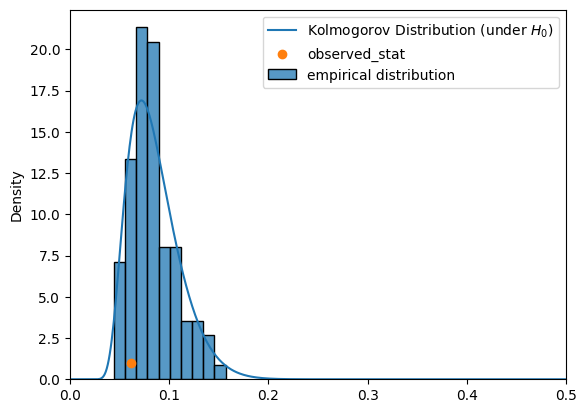

In [10]:
n = 100
obs_r, obs_eta = 1, 0.01
obs_x = sample_prior(obs_r, obs_eta, n)
true_cdf = compute_prior_cdf(obs_r, 0.00001)
kstest_stats, obs_stat, emp_p, k_p = empirical_pval(obs_x, obs_r, obs_eta, n, true_cdf)
plot_empirical_kolmogorov(kstest_stats, n, obs_stat)